# Floodify Flood Storage Area Modelling
This notebook is both a guide to and example of using the Floodify package to calculate the effectivenes of flood storage areas in reducing peakflow.  
Here, we look at the Q0100 peakflow benefit of 30,000 m<sup>3</sup> of storage across three upstream flood storage areas at a dowsntream confluence.

NB:
- Inflows must have the same timestep as dt
- FSA names in FSA configuration file must correspond to a file name in hypsometric_curves
- Any apparent references to physical locations are purely coincidental

In [1]:
import pandas as pd
import networkx as nx
from pathlib import Path
import json
import plotly.graph_objects as go
from floodify import Network, FSA, HypsoCurve

In [2]:
# Define constants
RETURN_PERIOD = "Q0100"

In [3]:
# Define input paths
p_dir_hypso_curve = Path("hypsometric_curves")
p_dir_inflow = Path("inflows")
p_fsa_config = Path("fsa_config/storage_30k.json")
p_optim_config = Path("optimisation_config/optimisation_config.json")

In [4]:
# Load in hypsometric curve data
hypso_curves = {}
for p in p_dir_hypso_curve.glob("*.csv"):
    df = pd.read_csv(p)
    hypso_curves[p.stem] = HypsoCurve(area=df["area"].values, elevation=df["elevation"].dropna().values)
# Load in inflow data
inflows = {p.stem: pd.read_csv(p) for p in p_dir_inflow.glob("*.csv")}

In [5]:
# Instantiate up FSAs
fsas = {}
for fsa_config in json.loads(p_fsa_config.read_text()):
    name = fsa_config["name"]
    fsas[name] = FSA(hypso_curve=hypso_curves[name], **fsa_config["parameters"])

In [6]:
# Initialise network
network = Network(dt=3.6)
# Add FSA nodes
for name in fsas:
    network.add_fsa(name=name, fsa=fsas[name])
# Add inflow nodes
inflow_names = ["Slippery", "W_02400d", "NB_01_FM", "NB_06_M", "NB_07_FM"]
for name in inflow_names:
    network.add_inflow(name=name, flow=inflows[RETURN_PERIOD][name])
# Add junctions to combine downstream flows
network.add_junction("n_beck")
network.add_junction("outfall")
# Add edges
network.add_edge("Slippery", "charcoal_hole")
network.add_edge("charcoal_hole", "dean_lane_upper")
network.add_edge("dean_lane_upper", "dean_lane_lower")
network.add_edge("dean_lane_lower", "n_beck")
network.add_edge("NB_01_FM", "n_beck")
network.add_edge("NB_06_M", "n_beck")
network.add_edge("NB_07_FM", "n_beck")
network.add_edge("n_beck", "outfall")
network.add_edge("W_02400d", "outfall")


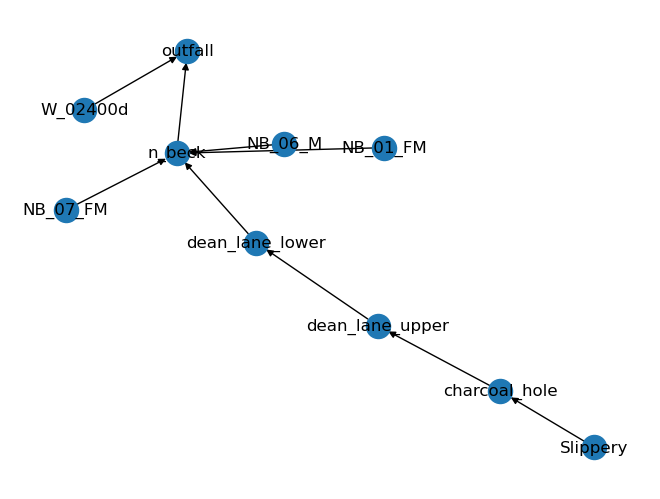

In [7]:
# Visualise network to see if it is connected correctly
nx.draw(network, with_labels=True)

In [8]:
# Load in optimisation parameters
parameter_config = json.loads(p_optim_config.read_text())

# Define the objective function to optimise the model
# Objective function takes network as argument and returns scalar value to minimised
def objective_function(network: Network) -> float:
    return  network.nodes["outfall"]["flow"].max()

result = network.optimise_network(
    parameter_config=parameter_config,
    objective_function=objective_function,
)

Now that we have optimised the network, we can look at the benefit it is having downstream at the outfall.

In [9]:
print(result.x)
print(result.fun)
print(result.fun - inflows[RETURN_PERIOD]["Total (W)"].max())

[1.         1.62092396 1.         1.67806445 1.         1.20465915]
93.56082115956318
-4.136322840436819


In [15]:
outfall_flow_fig = go.Figure()
outfall_flow_fig.add_trace(go.Scatter(y=network.nodes["outfall"]["flow"], name="Simulated"))
outfall_flow_fig.add_trace(go.Scatter(y=inflows[RETURN_PERIOD]["Total (W)"], name="Baseline"))
outfall_flow_fig.update_xaxes(title="Timestep")
outfall_flow_fig.update_yaxes(title="Flow (m<sup>3</sup>/s)")

In [16]:
fsa_flow_fig = go.Figure()
fsa_flow_fig.add_trace(go.Scatter(y=network.nodes["Slippery"]["flow"], name="Slippery Inflow"))
fsa_flow_fig.add_trace(go.Scatter(y=network.nodes["charcoal_hole"]["flow"], name="Charcoal Hole"))
fsa_flow_fig.add_trace(go.Scatter(y=network.nodes["dean_lane_upper"]["flow"], name="Dean Lane Upper"))
fsa_flow_fig.add_trace(go.Scatter(y=network.nodes["dean_lane_lower"]["flow"], name="Dean Lane Lower"))
fsa_flow_fig.update_xaxes(title="Timestep")
fsa_flow_fig.update_yaxes(title="Flow (m<sup>3</sup>/s)")

In [17]:
fsa_volume_fig = go.Figure()
fsa_volume_fig.add_trace(go.Scatter(y=network.nodes["charcoal_hole"]["volume"], name="Charcoal Hole"))
fsa_volume_fig.add_trace(go.Scatter(y=network.nodes["dean_lane_upper"]["volume"], name="Dean Lane Upper"))
fsa_volume_fig.add_trace(go.Scatter(y=network.nodes["dean_lane_lower"]["volume"], name="Dean Lane Lower"))
fsa_volume_fig.update_xaxes(title="Timestep")
fsa_volume_fig.update_yaxes(title="Flow (m<sup>3</sup>)")